In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from tensorflow.keras import models, layers
from tensorflow.keras import models, layers
from tensorflow.keras.saving import save_model

from keras import Model
from keras.optimizers import Adam, Nadam
from keras.models import load_model
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from utils.utils import plot_line, plot_metrics, plot_confusion_matrix

In [2]:
# Define the data directory and the classes
data_dir = '..\dataset'
classes = ('REAL', 'FAKE')

In [3]:
# Create image generators for training and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Load the training and testing images
train_images = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    subset="training",
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary')

val_images = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    subset="validation",
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary')

test_images = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary')

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [41]:
class InceptionLayer(layers.Layer):
    def __init__(self):
        super(InceptionLayer, self).__init__()
        self.branch_1 = layers.Conv2D(64, (1, 1), padding="same", activation="relu")
        self.branch_2 = models.Sequential([
            layers.Conv2D(64, (1, 1), padding="same", activation="relu"),
            layers.Conv2D(64, (3, 3), padding="same", activation="relu")
        ])
        self.branch_3 = models.Sequential([
            layers.Conv2D(64, (1, 1), padding="same", activation="relu"),
            layers.Conv2D(64, (5, 5), padding="same", activation="relu")
        ])
        self.branch_4 = models.Sequential([
            layers.MaxPooling2D((3, 3), strides=(1, 1), padding="same"),
            layers.Conv2D(64, (1, 1), padding="same", activation="relu")
        ])
        self.concat = layers.Concatenate()

    def call(self, inputs):
        branch_1_out = self.branch_1(inputs)
        branch_2_out = self.branch_2(inputs)
        branch_3_out = self.branch_3(inputs)
        branch_4_out = self.branch_4(inputs)
        output = self.concat([branch_1_out, branch_2_out, branch_3_out, branch_4_out])
        return output

In [42]:
def create_model(num_inception=1):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    for i in range(num_inception):
        model.add(InceptionLayer())
        model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

In [17]:
callback = EarlyStopping(monitor='val_loss', patience=3)

In [18]:
model = create_model()
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [19]:
history = model.fit(train_images, epochs=100, validation_data=val_images, callbacks=[callback])

Epoch 1/100
2500/2500 [==============================] - 248s 99ms/step - loss: 0.4655 - accuracy: 0.7826 - val_loss: 0.3626 - val_accuracy: 0.8395
Epoch 2/100
2500/2500 [==============================] - 139s 56ms/step - loss: 0.3612 - accuracy: 0.8444 - val_loss: 0.3121 - val_accuracy: 0.8694
Epoch 3/100
2500/2500 [==============================] - 139s 55ms/step - loss: 0.3343 - accuracy: 0.8591 - val_loss: 0.2911 - val_accuracy: 0.8811
Epoch 4/100
2500/2500 [==============================] - 636s 254ms/step - loss: 0.3220 - accuracy: 0.8651 - val_loss: 0.2895 - val_accuracy: 0.8827
Epoch 5/100
2500/2500 [==============================] - 390s 156ms/step - loss: 0.3089 - accuracy: 0.8704 - val_loss: 0.2716 - val_accuracy: 0.8903
Epoch 6/100
2500/2500 [==============================] - 135s 54ms/step - loss: 0.2991 - accuracy: 0.8757 - val_loss: 0.2955 - val_accuracy: 0.8759
Epoch 7/100
2500/2500 [==============================] - 138s 55ms/step - loss: 0.2937 - accuracy: 0.8779 - va

In [20]:
model2 = create_model(2)
model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history2 = model2.fit(train_images, epochs=100, validation_data=val_images, callbacks=[callback])

Epoch 1/100
2500/2500 [==============================] - 275s 110ms/step - loss: 0.5214 - accuracy: 0.7491 - val_loss: 0.5408 - val_accuracy: 0.7347
Epoch 2/100
2500/2500 [==============================] - 171s 68ms/step - loss: 0.4290 - accuracy: 0.8097 - val_loss: 0.5948 - val_accuracy: 0.7035
Epoch 3/100
2500/2500 [==============================] - 169s 68ms/step - loss: 0.3759 - accuracy: 0.8365 - val_loss: 0.5029 - val_accuracy: 0.7649
Epoch 4/100
2500/2500 [==============================] - 172s 69ms/step - loss: 0.3559 - accuracy: 0.8467 - val_loss: 0.5343 - val_accuracy: 0.7705
Epoch 5/100
2500/2500 [==============================] - 172s 69ms/step - loss: 0.3453 - accuracy: 0.8516 - val_loss: 0.5165 - val_accuracy: 0.7679
Epoch 6/100
2500/2500 [==============================] - 177s 71ms/step - loss: 0.3406 - accuracy: 0.8551 - val_loss: 0.4619 - val_accuracy: 0.7760
Epoch 7/100
2500/2500 [==============================] - 178s 71ms/step - loss: 0.3333 - accuracy: 0.8591 - val

In [25]:
model3 = create_model()
optimizer = Nadam(learning_rate=0.001)
model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history3 = model3.fit(train_images, epochs=100, validation_data=val_images, callbacks=[callback])

Epoch 1/100
2500/2500 [==============================] - 236s 94ms/step - loss: 0.4536 - accuracy: 0.7889 - val_loss: 0.3564 - val_accuracy: 0.8464
Epoch 2/100
2500/2500 [==============================] - 160s 64ms/step - loss: 0.3439 - accuracy: 0.8540 - val_loss: 0.3109 - val_accuracy: 0.8691
Epoch 3/100
2500/2500 [==============================] - 153s 61ms/step - loss: 0.3146 - accuracy: 0.8687 - val_loss: 0.2834 - val_accuracy: 0.8856
Epoch 4/100
2500/2500 [==============================] - 154s 62ms/step - loss: 0.2983 - accuracy: 0.8760 - val_loss: 0.2673 - val_accuracy: 0.8903
Epoch 5/100
2500/2500 [==============================] - 156s 62ms/step - loss: 0.2855 - accuracy: 0.8824 - val_loss: 0.2714 - val_accuracy: 0.8892
Epoch 6/100
2500/2500 [==============================] - 156s 62ms/step - loss: 0.2780 - accuracy: 0.8857 - val_loss: 0.2602 - val_accuracy: 0.8967
Epoch 7/100
2500/2500 [==============================] - 160s 64ms/step - loss: 0.2706 - accuracy: 0.8905 - val_

In [26]:
save_model(model, '../models/INCEPTION_MODULE')
loaded_model = load_model('../models/INCEPTION_MODULE')

INFO:tensorflow:Assets written to: ../models/INCEPTION_MODULE\assets


INFO:tensorflow:Assets written to: ../models/INCEPTION_MODULE\assets


In [27]:
save_model(model3, '../models/INCEPTION_MODULE_NADAM')
loaded_model2 = load_model('../models/INCEPTION_MODULE_NADAM')

INFO:tensorflow:Assets written to: ../models/INCEPTION_MODULE_NADAM\assets


INFO:tensorflow:Assets written to: ../models/INCEPTION_MODULE_NADAM\assets


In [28]:
hist_df = pd.DataFrame(history.history)
hist_df.columns = ['train_loss', 'train_acc', 'validation_loss', 'validation_acc']
hist_df.index = hist_df.index + 1
hist_df.to_csv('../history/INCEPTION_MODULE.csv')

In [29]:
hist_df2 = pd.DataFrame(history3.history)
hist_df2.columns = ['train_loss', 'train_acc', 'validation_loss', 'validation_acc']
hist_df2.index = hist_df2.index + 1
hist_df2.to_csv('../history/INCEPTION_MODULE_NADAM.csv')

In [30]:
loss, accuracy = loaded_model.evaluate(test_images)
print(f"Loss : {loss}")
print(f"Accuracy : {accuracy}")

625/625 [==============================] - 153s 245ms/step - loss: 0.4960 - accuracy: 0.7930
Loss : 0.4960031807422638
Accuracy : 0.7929999828338623


In [31]:
loss, accuracy = loaded_model2.evaluate(test_images)
print(f"Loss : {loss}")
print(f"Accuracy : {accuracy}")

625/625 [==============================] - 11s 17ms/step - loss: 0.3747 - accuracy: 0.8378
Loss : 0.3746694028377533
Accuracy : 0.8378000259399414


In [32]:
y_true = []
y_pred = []
y_pred_nadam = []
for batch_id in range(len(test_images)):
    batch_images = test_images[batch_id][0]
    batch_labels = test_images[batch_id][1]
    batch_predictions = loaded_model.predict(batch_images)
    batch_predictions2 = loaded_model2.predict(batch_images)
    batch_predictions = (batch_predictions > 0.5).astype(int)
    batch_predictions2 = (batch_predictions2 > 0.5).astype(int)
    y_true.extend(batch_labels)
    y_pred.extend(batch_predictions)
    y_pred_nadam.extend(batch_predictions2)

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


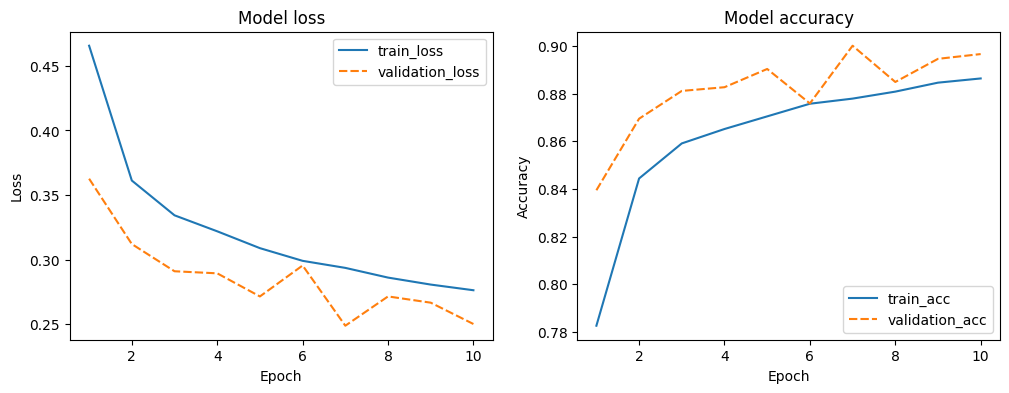

In [33]:
plot_line(hist_df)

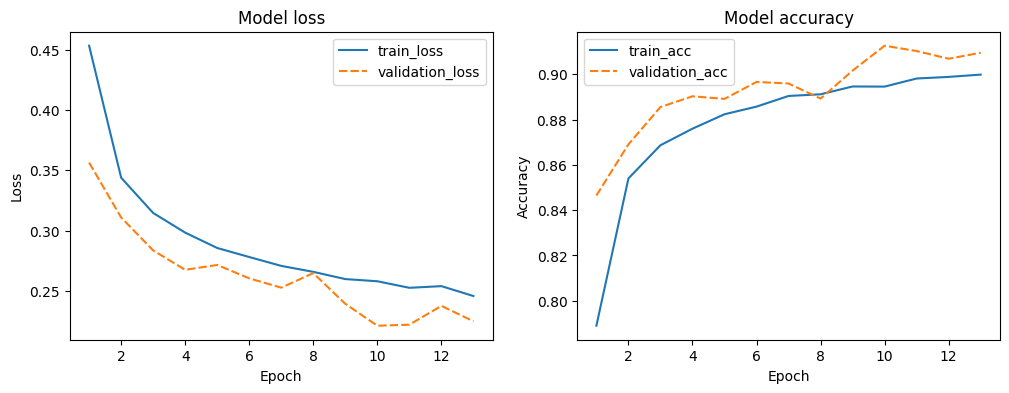

In [34]:
plot_line(hist_df2)

In [35]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)

print('The f1 score on the test images is:', f1)
print('The precision on the test images is:', prec)
print('The recall on the test images is:', rec)
print('The accuracy score on the test images is:', acc)

The f1 score on the test images is: 0.7413469948769212
The precision on the test images is: 0.9878454878454879
The recall on the test images is: 0.5933
The accuracy score on the test images is: 0.793


In [36]:
acc = accuracy_score(y_true, y_pred_nadam)
f1 = f1_score(y_true, y_pred_nadam)
prec = precision_score(y_true, y_pred_nadam)
rec = recall_score(y_true, y_pred_nadam)

print('The f1 score on the test images is:', f1)
print('The precision on the test images is:', prec)
print('The recall on the test images is:', rec)
print('The accuracy score on the test images is:', acc)

The f1 score on the test images is: 0.8083874778499704
The precision on the test images is: 0.9874458874458875
The recall on the test images is: 0.6843
The accuracy score on the test images is: 0.8378


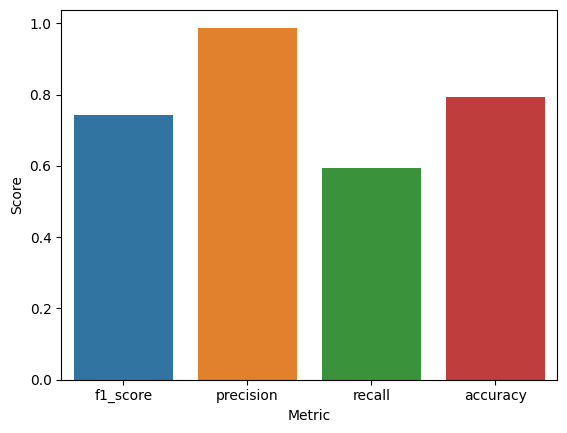

In [37]:
plot_metrics(y_true, y_pred)

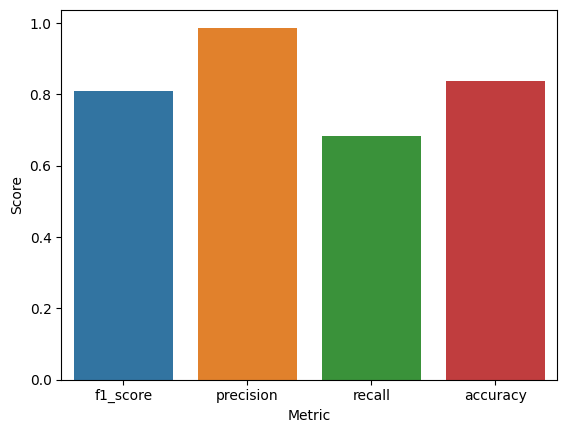

In [38]:
plot_metrics(y_true, y_pred_nadam)

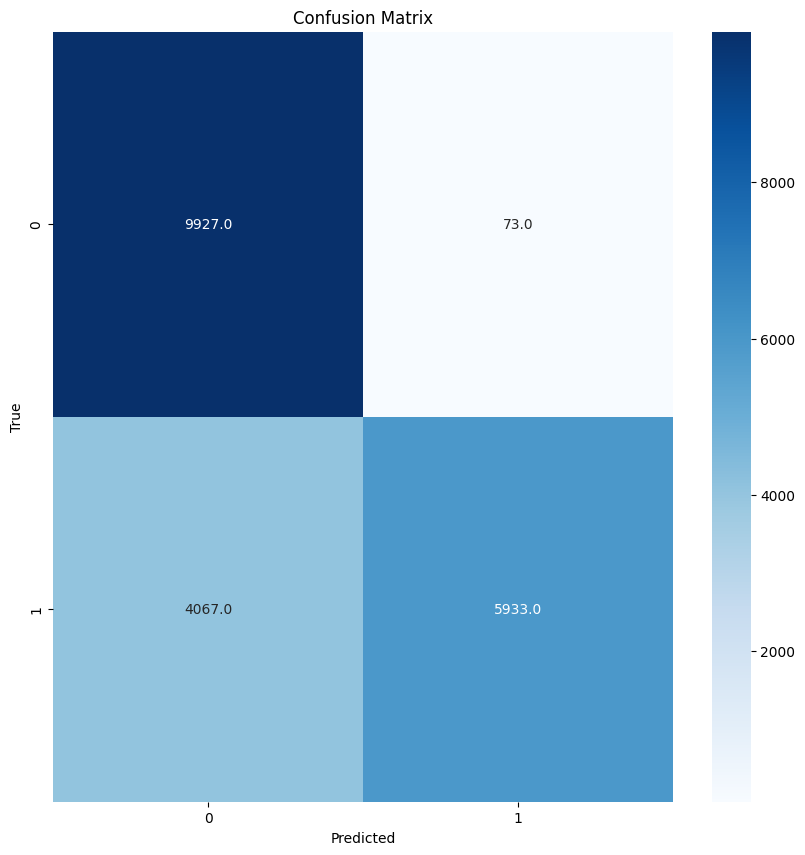

In [39]:
plot_confusion_matrix(y_true, y_pred)

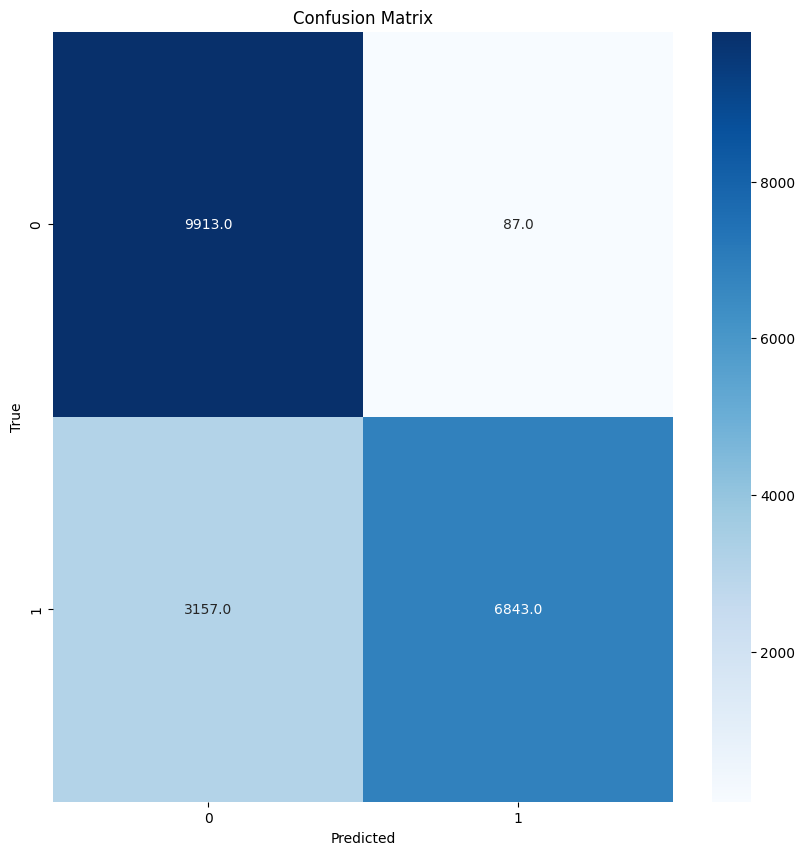

In [40]:
plot_confusion_matrix(y_true, y_pred_nadam)

In [45]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(InceptionLayer())
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(InceptionLayer())
model4.add(layers.Dropout(0.2))
model4.add(layers.Flatten())
model4.add(layers.Dense(128, activation="relu"))
model4.add(layers.Dense(1, activation="sigmoid"))

In [46]:
optimizer = Nadam(learning_rate=0.001)
model4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history4 = model4.fit(train_images, epochs=100, validation_data=val_images, callbacks=[callback])

Epoch 1/100
2500/2500 [==============================] - 191s 75ms/step - loss: 0.4390 - accuracy: 0.7946 - val_loss: 0.3642 - val_accuracy: 0.8372
Epoch 2/100
2500/2500 [==============================] - 98s 39ms/step - loss: 0.3342 - accuracy: 0.8555 - val_loss: 0.3111 - val_accuracy: 0.8705
Epoch 3/100
2500/2500 [==============================] - 98s 39ms/step - loss: 0.3053 - accuracy: 0.8709 - val_loss: 0.2897 - val_accuracy: 0.8787
Epoch 4/100
2500/2500 [==============================] - 98s 39ms/step - loss: 0.2919 - accuracy: 0.8778 - val_loss: 0.3015 - val_accuracy: 0.8708
Epoch 5/100
2500/2500 [==============================] - 99s 40ms/step - loss: 0.2809 - accuracy: 0.8822 - val_loss: 0.2681 - val_accuracy: 0.8878
Epoch 6/100
2500/2500 [==============================] - 98s 39ms/step - loss: 0.2700 - accuracy: 0.8884 - val_loss: 0.2580 - val_accuracy: 0.8978
Epoch 7/100
2500/2500 [==============================] - 101s 40ms/step - loss: 0.2642 - accuracy: 0.8901 - val_loss:

In [47]:
save_model(model4, '../models/INCEPTION_MODULE_V2')
loaded_model3 = load_model('../models/INCEPTION_MODULE_V2')

INFO:tensorflow:Assets written to: ../models/INCEPTION_MODULE_V2\assets


INFO:tensorflow:Assets written to: ../models/INCEPTION_MODULE_V2\assets


In [48]:
hist_df3 = pd.DataFrame(history4.history)
hist_df3.columns = ['train_loss', 'train_acc', 'validation_loss', 'validation_acc']
hist_df3.index = hist_df3.index + 1
hist_df3.to_csv('../history/INCEPTION_MODULE_V2.csv')

In [49]:
loss, accuracy = loaded_model3.evaluate(test_images)
print(f"Loss : {loss}")
print(f"Accuracy : {accuracy}")

625/625 [==============================] - 9s 14ms/step - loss: 0.3644 - accuracy: 0.8551
Loss : 0.3644369840621948
Accuracy : 0.8551499843597412


In [50]:
y_true = []
y_pred2 = []
for batch_id in range(len(test_images)):
    batch_images = test_images[batch_id][0]
    batch_labels = test_images[batch_id][1]
    batch_predictions = loaded_model3.predict(batch_images)
    batch_predictions = (batch_predictions > 0.5).astype(int)
    y_true.extend(batch_labels)
    y_pred2.extend(batch_predictions)

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


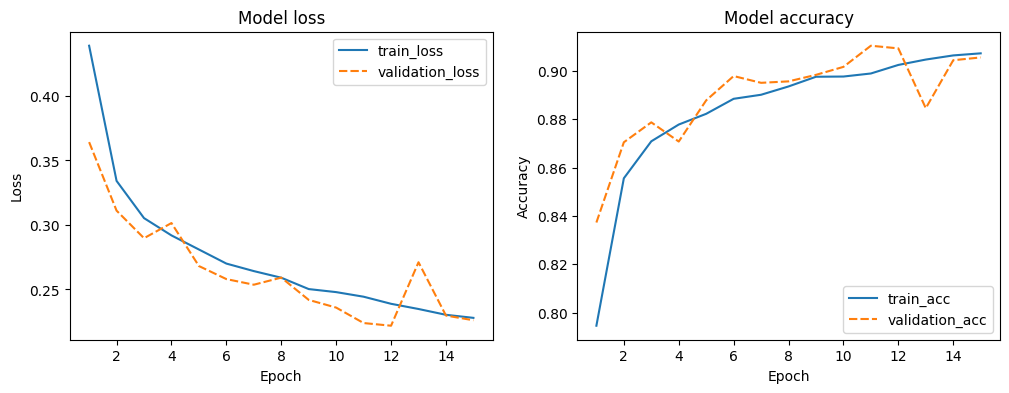

In [51]:
plot_line(hist_df3)

In [52]:
acc = accuracy_score(y_true, y_pred2)
f1 = f1_score(y_true, y_pred2)
prec = precision_score(y_true, y_pred2)
rec = recall_score(y_true, y_pred2)

# Print the metrics
print('The f1 score on the test images is:', f1)
print('The precision on the test images is:', prec)
print('The recall on the test images is:', rec)
print('The accuracy score on the test images is:', acc)

The f1 score on the test images is: 0.8340113447544835
The precision on the test images is: 0.9765195223399973
The recall on the test images is: 0.7278
The accuracy score on the test images is: 0.85515


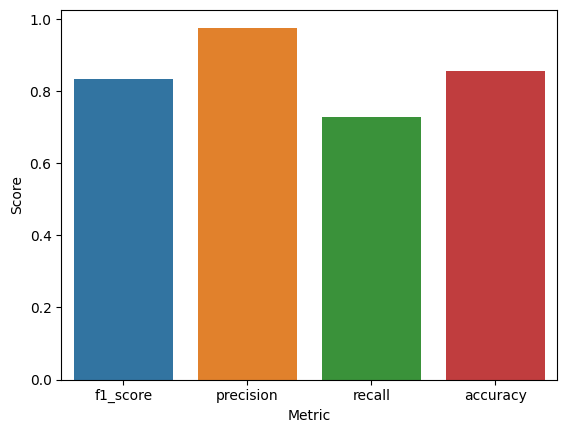

In [53]:
plot_metrics(y_true, y_pred2)

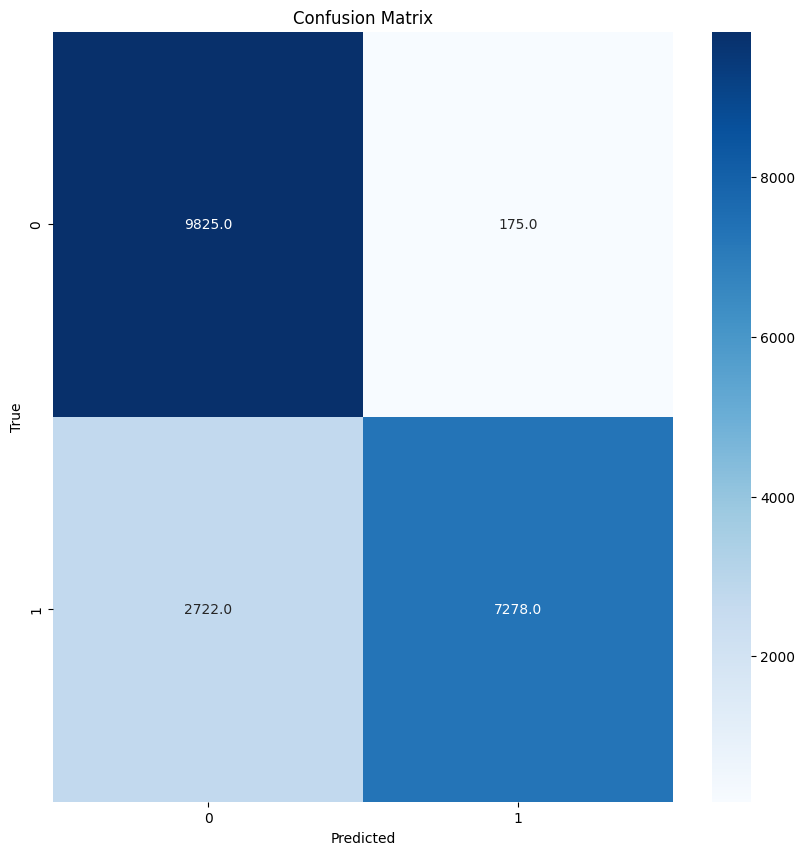

In [54]:
plot_confusion_matrix(y_true, y_pred2)